# Simulation RL

## Modules

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import pickle

In [2]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv

In [3]:
import matplotlib.pyplot as plt

## Tickers

In [4]:
tickers_trad = ['PETR4.SA', 'VALE3.SA']

In [5]:
ticker_bench = '^BVSP'

## Data

In [6]:
with open('../data/train.pickle', 'rb') as handle:
    train_data = pickle.load(handle)

In [7]:
with open('../data/valid.pickle', 'rb') as handle:
    valid_data = pickle.load(handle)

In [8]:
with open('../data/test.pickle', 'rb') as handle:
    test_data = pickle.load(handle)

## Environment

In [9]:
class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    # start simulation
    def __init__(self, stock_data, transaction_cost_percent = 0.005):
        super(StockTradingEnv, self).__init__()

        # remove empty data
        self.stock_data = {ticker: df for ticker, df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All data provided is empty")

        # calculate the size of one stock data
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # define action and observation space (between -1 (sell) and 1 (buy), shape is n tickers)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape = (len(self.tickers),), dtype = np.float32)

        # Observation space: price data for each stock + balance + shares held + net worth + max net worth + current step
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape = (self.obs_shape,), dtype = np.float32)

        # Account balance
        self.initial_balance = 1000
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}

        # set current step
        self.current_step = 0

        # minimum length of data across all stocks
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # costs
        self.transaction_cost_percent = transaction_cost_percent

    # update next observation
    def _next_observation(self):
        # initialize frame
        frame = np.zeros(self.obs_shape)

        # Add stock data each ticker
        idx = 0

        # loop each ticker
        for ticker in self.tickers:
            
            # get dataframe from ticker
            df = self.stock_data[ticker]

            # If the current step is less than the length of the DataFrame, add the price data for the current step
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            # Otherwise, add the last price data available
            elif len(df) > 0:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            
            # Move the index to the next ticker
            idx += self.n_features

        # Add balance, shares held, net worth, max net worth, and current step
        frame[-4-len(self.tickers)] = self.balance # Balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers] # Shares hold
        frame[-3] = self.net_worth # Net worth
        frame[-2] = self.max_net_worth # Max net worth
        frame[-1] = self.current_step # current step
        
        return frame

    # reset environment
    def reset(self, seed = None, option = None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0

        return self._next_observation(), {}

    # what to do in each step
    def step(self, actions):
        # update the current step
        self.current_step += 1

        # check if reached the maximum number of steps
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}
        
        current_prices = {}

        # loop each ticker and perform the actions
        for i, ticker in enumerate(self.tickers):
            # get the current price
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']

            # get the action
            action = actions[i]

            # results of the actions
            # buy
            if action > 0:
                # calculate the number of shares to buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])

                # calculate the cost of shares
                cost = shares_to_buy * current_prices[ticker]

                # transaction cost
                transaction_cost = cost * self.transaction_cost_percent

                # update the balance
                self.balance -= (cost + transaction_cost)

                # update shares hold
                self.shares_held[ticker] += shares_to_buy
            # sell
            elif action < 0:
                # calculate the number of shares to sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                
                # calculate sale value
                sale = shares_to_sell * current_prices[ticker]

                # transaction cost
                transaction_cost = sale * self.transaction_cost_percent

                # update the balance
                self.balance += (sale - transaction_cost)

                # update shares hold
                self.shares_held[ticker] -= shares_to_sell

                # update total shares hold
                self.total_shares_sold[ticker] += shares_to_sell

                # update total sales value
                self.total_sales_value[ticker] += sale
        
        # calculate net worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        
        # update max net worth
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        
        # reward
        reward = self.net_worth - self.initial_balance
        
        # check if episode is done
        done = self.net_worth <= 0 or self.current_step >= self.max_steps

        # next observation
        obs = self._next_observation()
        
        return obs, reward, done, False, {}
    
    def close(self):
        pass

    def update_stock_data(self, new_stock_data, transaction_cost_percent = None):
        """
        Update the environment with new stock data.

        Parameters:
        new_stock_data (dict): Dictionary containing new stock data, with keys as stock tickers and values as DataFrames.
        """
        # remove empty data
        self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All data provided is empty")

        # update number of features
        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)

        # update observation space
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape = (self.obs_shape,), dtype = np.float32)

        # update maximum steps
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # update transction cost
        if transaction_cost_percent is not None:
            self.transaction_cost_percent = transaction_cost_percent
        
        # reset environment
        self.reset()

        print(f"The environment has been updated with {len(self.tickers)} new stocks.")

In [10]:
testar_env = StockTradingEnv(valid_data)

In [11]:
testar_env.step([1,2])

(array([ 4.02700005e+01,  4.07500000e+01,  4.00200005e+01,  4.00800018e+01,
         2.19880000e+07, -2.76049683e-01, -7.37461460e-03,  4.10557221e+01,
        -1.51228004e+02,  3.23990658e+01,  6.69499969e+01,  6.71999969e+01,
         6.63899994e+01,  6.67300034e+01,  1.31480000e+07, -5.30955595e-02,
        -1.04105829e-01,  5.37258791e+01,  2.39148319e+01,  4.38212343e+01,
         3.32703558e+01,  2.40000000e+01,  0.00000000e+00,  9.95190400e+02,
         1.00000000e+03,  1.00000000e+00]),
 -4.809600219726576,
 False,
 False,
 {})

## Train models

- RL models

In [12]:
# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps, progress_bar=False):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps, progress_bar=progress_bar)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

In [13]:
# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps, progress_bar=False):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps, progress_bar=progress_bar)
    
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

- Create enviroment and models

In [14]:
def create_env_and_train_agents(data, total_time_steps):
    # create environment
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # train A2C
    a2c_agent = A2CAgent(env, total_time_steps)

    # train DDPG
    ddpg_agent = DDPGAgent(env, total_time_steps)

    return env, a2c_agent, ddpg_agent

In [15]:
env = DummyVecEnv([lambda: StockTradingEnv(train_data)])
a2c_agent = A2CAgent(env, 10000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 879       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -2.86     |
|    explained_variance | 2.91e-05  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -3.59e+03 |
|    std                | 1.01      |
|    value_loss         | 1.6e+06   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 907       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -2.87     |
|    explained_variance | -0.000232 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199    

In [16]:
obs = env.reset()
obs

array([[ 2.9000000e+01,  2.9080000e+01,  2.8670000e+01,  2.8850000e+01,
         4.2297500e+07, -4.7114113e-01, -3.4467423e-01,  3.4468925e+01,
        -1.1397976e+02,  4.2996254e+01,  5.1700001e+01,  5.1889999e+01,
         5.0459999e+01,  5.0750000e+01,  2.3323000e+07, -5.6944096e-01,
         4.7343299e-03,  4.0576508e+01, -1.6024629e+02,  2.3525429e+01,
         1.0000000e+03,  0.0000000e+00,  0.0000000e+00,  1.0000000e+03,
         1.0000000e+03,  0.0000000e+00]], dtype=float32)

In [17]:
a2c_agent.predict(obs)

array([[1.        , 0.09296314]], dtype=float32)

In [18]:
env.step(a2c_agent.predict(obs))

(array([[ 2.8280001e+01,  2.9040001e+01,  2.8180000e+01,  2.8940001e+01,
          4.4266800e+07, -4.6685681e-01, -3.6911076e-01,  3.6565643e+01,
         -1.1823966e+02,  4.8021954e+01,  4.9970001e+01,  5.1500000e+01,
          4.9799999e+01,  5.1500000e+01,  2.3083200e+07, -6.8986267e-01,
         -1.3418508e-01,  4.3459919e+01, -1.4085214e+02,  2.3704050e+01,
          1.6607500e+01,  0.0000000e+00,  1.9000000e+01,  9.9510748e+02,
          1.0000000e+03,  1.0000000e+00]], dtype=float32),
 array([-4.8925], dtype=float32),
 array([False]),
 [{'TimeLimit.truncated': False}])

- Visualization

In [19]:
# Function to visualize portfolio changes
def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

In [20]:
# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

In [21]:
# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

- Test Agent

In [22]:
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000).
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps':[],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
              }
    
    # reset environment
    obs = env.reset()

    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)

        if visualize:
            env.render()

        # track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # update shares held
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)

        if dones:
            obs = env.reset()

    return metrics

- Test and visualize

In [23]:
def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")
    
    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))

In [24]:
def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            net_worths = metrics['net_worths']
            # Calculate daily returns
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = (avg_return - risk_free_rate) / std_return

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

### Run simulations

In [25]:
total_timesteps = 10000

In [26]:
# train agents
env, a2c_agent, ddpg_agent = create_env_and_train_agents(train_data, total_timesteps)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 823       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -2.89     |
|    explained_variance | 2.64e-05  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -6.73e+03 |
|    std                | 1.03      |
|    value_loss         | 3.46e+06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 810       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -2.9      |
|    explained_variance | -3.03e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199    

Testing A2C Agent...


/home/dasa/Desktop/estudos-pdi/rl-trading/.env/lib/python3.12/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


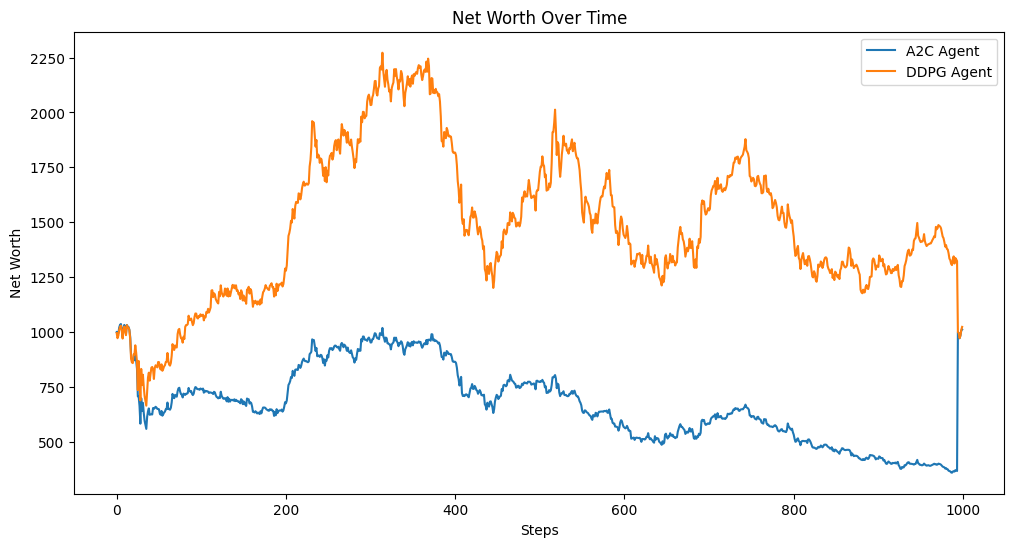

In [27]:
# test
n_tests = 1000
agents = {
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
}
test_and_visualize_agents(env, agents, train_data, n_tests=n_tests)

In [29]:
test_agents = {
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
}

,Agent,Return,Standard Deviation,Sharpe Ratio
0,A2C Agent,0.000816,0.051286,0.015902
1,DDPG Agent,0.000379,0.026372,0.014368


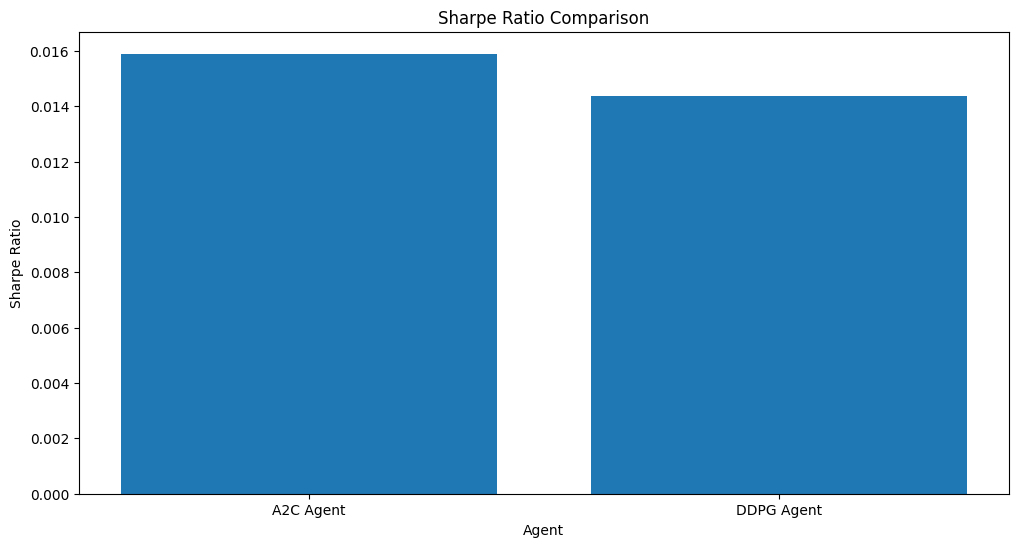

In [30]:
test_agents_metrics = [test_agent(env, agent, train_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))

- Evaluation

In [31]:
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

Testing A2C Agent...


/home/dasa/Desktop/estudos-pdi/rl-trading/.env/lib/python3.12/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


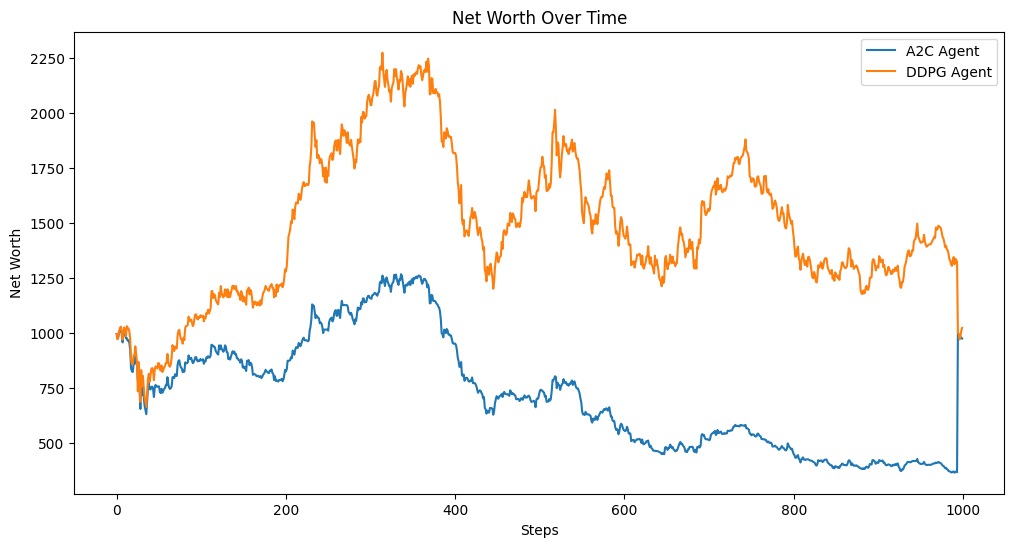

In [32]:
n_tests = 1000
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

,Agent,Return,Standard Deviation,Sharpe Ratio
0,A2C Agent,0.000606,0.040072,0.015132
1,DDPG Agent,0.000379,0.026372,0.014368


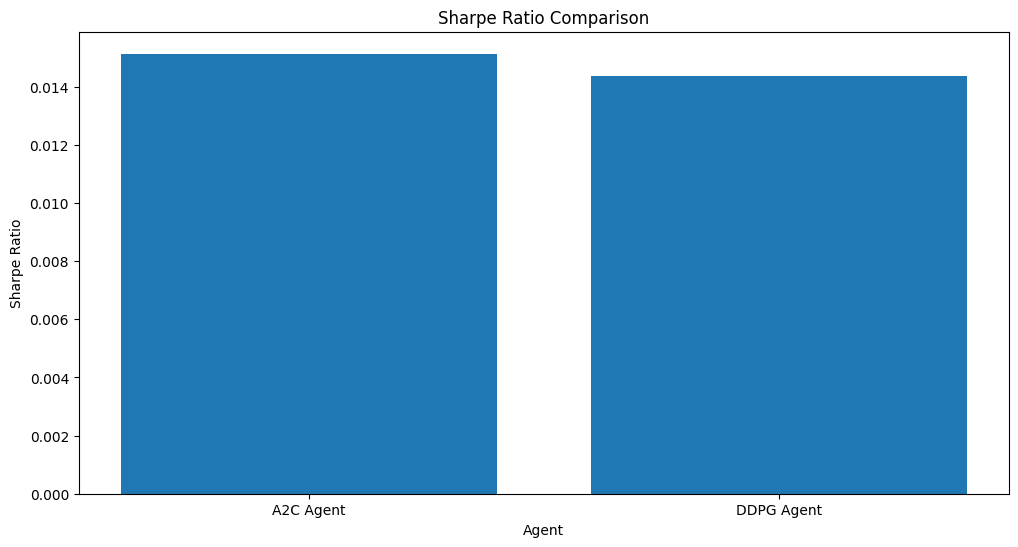

In [33]:
# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))